# Исследование поведения клиентов оператора сотовой связи
<a id='start'></a>

# Содержание

1. [Задача, описание данных, план исследования](#stage1)
2. [Изучение данных](#stage2)  
    2.1. [Вывод](#stage2_)
3. [Предобработка данных](#stage3)  
    3.1. [Вывод](#stage3_)
4. [Дополнительные расчёты](#stage4)  
    4.1. [Вывод](#stage4_)
5. [Анализ данных](#stage5)  
    5.1. [Вывод](#stage5_)
6. [Общий вывод](#end)

## Задача, описание данных, план исследования
<a id='stage1'></a>

Задача: определить, какой из двух тарифных планов оператора сотовой связи приносит большую прибыль.

    Иследование для федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
 
    Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов - в нашем распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Описание тарифа «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

Описание тарифа «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей

Примечание:
Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

В данных есть следующие столбцы:

Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

План исследования:
        
    - изучение данных
    - предобработка данных (обработка пропусков, аномалий и дубликатов, работа с типами данных)
    - расчеты недостающих для исследования параметров
    - анализ данных (сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц, проверка гипотез)
    - выводы

## Изучение данных 
<a id='stage2'></a>

[к содержанию](#start)

Откроем таблицы с данными и изучим их

In [1]:
from io import BytesIO
import requests

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

pd.options.display.float_format = '{:,.2f}'.format # форматирует все длинные значения в проекте

In [2]:
spreadsheet_id = '1ERqjrUwKYIUbs_ZKbOOjC2uaa2vdI7PoDu0RkYnyOvY'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
users = pd.read_csv(BytesIO(r.content))
users 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице users 500 строк и 8 столбцов. Столбцы именованы корректно. Данные целочисленного и строкового типов.

Пропуски есть только в одном столбце churn_date — дата прекращения пользования тарифом. Но нам известно, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Поэтому с этими пропусками ничего делать не нужно.


In [4]:
# запишем в переменную и выведем на экран первые строки таблицы calls и информацию о ней
spreadsheet_id = '1TnKspOZgKfK7-IFfWLmNV1PUGfF-0hQgvpiGGWXNEpw'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
calls = pd.read_csv(BytesIO(r.content))
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице calls 202607 строк и 4 столбца. Столбцы именованы корректно. Данные целочисленного, вещественного и строкового типов. Пропусков нет.

In [6]:
# запишем в переменную и выведем на экран первые строки таблицы messages и информацию о ней
spreadsheet_id = '1perq6MoJy4Rf2POHOzYhoc6HRT04BfNQp5WNW1PCjhQ'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
messages = pd.read_csv(BytesIO(r.content))
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице messages 123036 строк и 3 столбца. Столбцы именованы корректно. Данные целочисленного и строкового типов. Пропусков нет.

In [8]:
# запишем в переменную и выведем на экран первые строки таблицы internet и информацию о ней
spreadsheet_id = '1mc8fQ3eE1hndL7qqlK0MPb8KC2llrTJnYK8F3ca_mb8'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
internet = pd.read_csv(BytesIO(r.content), index_col=0)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


В таблице internet 149396 строк и 5 столбцов. Столбцы именованы корректно. Данные целочисленного, вещественного и строкового типов. Пропусков нет.

In [10]:
# запишем в переменную и выведем на экран первые строки таблицы tariffs и информацию о ней
spreadsheet_id = '1XEB3euAsH-GyWpaCjP-3Z_i134hddhwqXmCqYWp53cU'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
tariffs = pd.read_csv(BytesIO(r.content))
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице tariffs 2 строки и 8 столбцов. Столбцы именованы корректно. Данные целочисленного и строкового типов. Пропусков нет.

На первый взгляд, в таблицах calls, messages и internet столбец id фактически дублирует столбец с id строк в таблице, и его можно удалить. Но возможны ситуации, когда, например, один и тот же пользователь отправил несколько СМС в один день. В таком случае дата и user_id будут одинаковыми, и мы можем посчитать такие строки дубликатами. Столбец id нужен для маркировки каждого уникального звонка, СМС или интернет-соединения пользователя. Поэтому эти столбцы нужно оставить.

### Вывод
<a id='stage2_'></a>

Во всех датафреймах столбцы именованы корректно, пропусков, которые нужно обработать, нет. Данные целочисленного, вещественного и строкового типов.

## Предобработка данных
<a id='stage3'></a>

[к содержанию](#start)

Проверим таблицы на дубликаты и аномалии и изменим время на удобный формат datetime.

In [12]:
# проверим на дубликаты и аномалии значимые столбцы таблицы user
users.tail()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


In [13]:
users['age'].unique()

array([52, 41, 59, 23, 68, 67, 21, 65, 63, 24, 26, 44, 38, 36, 64, 58, 73,
       71, 61, 72, 42, 56, 32, 62, 20, 51, 28, 66, 31, 37, 47, 40, 69, 48,
       33, 39, 43, 46, 45, 55, 53, 34, 49, 25, 18, 70, 50, 19, 54, 60, 29,
       27, 74, 22, 30, 75, 57, 35], dtype=int64)

In [14]:
users['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

In [15]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

In [16]:
# проверим, есть ли явные дубликаты 
users.duplicated().sum()

0

In [17]:
# изменим формат времени на datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Неявных и явных дубликатов в таблице users нет, аномалий тоже. Тип данных в столбце с временем изменили.

In [18]:
# проверим на дубликаты и аномалии столбцы таблицы calls
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [19]:
# проверим, есть ли явные дубликаты
calls.duplicated().sum()

0

In [20]:
# есть ли отрицательные значения
calls[calls['duration'] < 0]['duration'].count()

0

Оператор всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Длительность звонка указана в минутах. Округлим длительности звонков до целых чисел в большую сторону.

In [21]:
calls['duration'] = np.ceil(calls['duration']).astype(int)
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [22]:
# изменим формат времени звонков на datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


Нулевые значения в duration говорят нам о пропущенных звонках, это не ошибка, и с данными ничего делать не нужно. Посчитаем долю таких звонков.

In [23]:
calls[calls['duration'] == 0]['duration'].count() / calls['duration'].count()

0.19551644316336553

Почти 20% пропущенных звонков - это достаточно много. Проверим, как распределены пропущенные звонки по месяцам - равномерно или нет.

In [24]:
calls['call_month'] = calls['call_date'].dt.month # создадим столбец с номерами месяцев
calls.query('duration == 0').pivot_table(index = 'call_month', values = 'user_id', aggfunc = 'count')

,user_id
call_month,
1,312
2,623
3,1304
4,1768
5,2531
6,2883
7,3518
8,4231
9,4615


Пропущенные звонки есть во всех месяцах и нарастают к концу года. Проверим как ведут себя все звонки по месяцам.

In [25]:
calls.pivot_table(index = 'call_month', values = 'user_id', aggfunc = 'count')

,user_id
call_month,
1,1476
2,3328
3,6687
4,9272
5,12647
6,14716
7,18298
8,21488
9,24061


Итак, общее количество звонков по месяцам тоже нарастает к концу года. Судя по всему, тут нет аномалии, и пропущенные звонки распределены по месяцам равномерно.

Проверим, какой процент пропущенных звонков приходится на каждого пользователя и найдем пользователей с максимальными значениями.

In [26]:
# выберем только пропущенные звонки для каждого пользователя
i = calls.query('duration == 0').pivot_table(index = 'user_id', values = 'duration', aggfunc = 'count')

# посчитаем все звонки по каждому пользователю с пропущенными звонками
i['duration_sum'] = calls.groupby('user_id')['duration'].count()

# добавим тариф
i = i.merge(users[['user_id', 'tariff']], on='user_id', how='left')

# посчитаем процент долю звонков от общего количества и отсортируем по убыванию
i['duration_%'] = i['duration'] / i['duration_sum'] 
i.sort_values(by='duration_%', ascending=False).head()

,user_id,duration,duration_sum,tariff,duration_%
253,1257,7,14,ultra,0.50
178,1181,25,78,smart,0.32
392,1398,16,53,smart,0.30
16,1016,6,20,ultra,0.30
367,1373,7,24,smart,0.29


In [27]:
i['duration_%'].describe()

count   492.00
mean      0.20
std       0.03
min       0.09
25%       0.18
50%       0.20
75%       0.21
max       0.50
Name: duration_%, dtype: float64

Как видим, среднее количество пропущенных звонков на каждого пользователя достаточно высокое и практически равно доле пропущенных звонков по всей таблице. Есть только один клиент, у которого 50% звонков пропущенные. Пропущенные звонки есть у клиентов с обоими тарифами. Значит, в количестве пропущенных звонков нет аномалии. 

Неявных и явных дубликатов в таблице calls нет, аномалий тоже. Тип данных в столбце с временем изменили, длительность звонков округлили в соответствии с условиями тарифов.

In [28]:
# проверим на дубликаты и аномалии столбцы таблицы messages
messages.tail()

,id,message_date,user_id
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


In [29]:
# проверим, есть ли явные дубликаты
messages.duplicated().sum()

0

In [30]:
# изменим формат времени сообщений на datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Дубликатов в таблице messages нет. Тип данных в столбце с временем изменили.

In [31]:
# проверим на дубликаты и аномалии столбцы таблицы internet
internet.tail()

,id,mb_used,session_date,user_id
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,"1,246.32",2018-11-26,1499
149395,1499_156,544.37,2018-10-26,1499


In [32]:
# есть ли отрицательные значения
internet[internet['mb_used'] < 0]['mb_used'].count()

0

In [33]:
# проверим, есть ли явные дубликаты
internet.duplicated().sum()

0

In [34]:
# изменим формат времени сессий на datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


Есть нулевые значения в mb_used. Возможно, это очень короткие сессии, когда клиент ничего не скачивал. Проверим, сколько таких значений.

In [35]:
internet[internet['mb_used'] == 0.00]['mb_used'].count() / internet['mb_used'].count()

0.13118155773916304

Достаточно весомая часть нулевых сессий, проверим распределение по месяцам.

In [36]:
internet['session_month'] = internet['session_date'].dt.month
internet.query('mb_used == 0.00').pivot_table(index = 'session_month', values = 'user_id', aggfunc = 'count')

,user_id
session_month,
1,151
2,378
3,623
4,819
5,1199
6,1401
7,1760
8,2083
9,2314


Распределение нулевых сессий по месяцам без резких отклонений, посмотрим на распределение по клиентам.

In [37]:
# выберем только пропущенные сессии для каждого пользователя
i = internet.query('mb_used == 0.00').pivot_table(index = 'user_id', values = 'mb_used', aggfunc = 'count')
i = i.rename(columns = {'mb_used':'session_0'})

# посчитаем все сессии по каждому пользователю с пропущенными звонками
i['session_sum'] = internet.groupby('user_id')['mb_used'].count()

# добавим тариф
i = i.merge(users[['user_id', 'tariff']], on='user_id', how='left')

# посчитаем процент долю звонков от общего количества и отсортируем по убыванию
i['session_%'] = i['session_0'] / i['session_sum'] 
i.sort_values(by='session_%', ascending=False).head()

,user_id,session_0,session_sum,tariff,session_%
428,1434,13,52,smart,0.25
41,1041,22,91,smart,0.24
189,1190,11,46,smart,0.24
348,1351,14,60,smart,0.23
320,1322,49,219,smart,0.22


In [38]:
i['session_%'].describe()

count   494.00
mean      0.13
std       0.06
min       0.01
25%       0.06
50%       0.15
75%       0.17
max       0.25
Name: session_%, dtype: float64

Как мы видим, доля пропущенных сессий по клиентам не содержит аномалий в виде большого количества для одного клиента. 

Дубликатов и аномалий в таблице internet нет. Тип данных в столбце с временем изменили.

### Вывод
<a id='stage3_'></a>

Все таблицы проверены на дубликаты и аномалии, тип данных для столбцов с датами изменен на формат времени datetime. Таблицы готовы к дальнейшей работе.

## Дополнительные расчёты
<a id='stage4'></a>

[к содержанию](#start)

Посчитаем для каждого пользователя:

    - количество сделанных звонков и израсходованных минут разговора по месяцам; 
    - количество отправленных сообщений по месяцам; 
    - объем израсходованного интернет-трафика по месяцам; 
    - помесячную выручку с каждого пользователя. 

In [39]:
# рассчитаем количество сделанных звонков и израсходованных минут разговора по месяцам
# для этого сгруппируем таблицу со звонками по id клиента и по месяцу звонка 
# и посчитаем количество и суммарную продолжительность звонков

calls_month = calls.groupby(by=['user_id','call_month'],as_index=False).agg({'duration':['count','sum']})
calls_month.head()

user_id call_month duration     
                        count  sum
0    1000          5       22  159
1    1000          6       43  172
2    1000          7       47  340
3    1000          8       52  408
4    1000          9       58  466

In [40]:
# избавимся от мультииндексов

calls_month.columns = calls_month.columns.to_flat_index()
calls_month = calls_month.rename(columns={('user_id',''):'user_id', ('call_month',''):'month', ('duration', 'count'):'calls_count', ('duration', 'sum'):'calls_sum'})

calls_month.head()

,user_id,month,calls_count,calls_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [41]:
# по такой же схеме рассчитаем количество отправленных сообщений по месяцам
messages['message_month'] = messages['message_date'].dt.month
messages_month = messages.groupby(by=['user_id','message_month'],as_index=False).agg({'id':'count'})
messages_month = messages_month.rename(columns={'message_month':'month', 'id':'messages_count'})

messages_month.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [42]:
# по такой же схеме рассчитаем объем израсходованного интернет-трафика по месяцам
internet_month = internet.groupby(by=['user_id','session_month'],as_index=False).agg({'mb_used':'sum'})

internet_month = internet_month.rename(columns={'session_month':'month','mb_used':'mb_used'})

internet_month.head()

,user_id,month,mb_used
0,1000,5,"2,253.49"
1,1000,6,"23,233.77"
2,1000,7,"14,003.64"
3,1000,8,"14,055.93"
4,1000,9,"14,568.91"


Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Добавим столбец с гигабайтами израсходованного трафика.

In [43]:
internet_month['gb_used'] = np.ceil(internet_month['mb_used'] / 1024).astype('int')
internet_month.head()

,user_id,month,mb_used,gb_used
0,1000,5,"2,253.49",3
1,1000,6,"23,233.77",23
2,1000,7,"14,003.64",14
3,1000,8,"14,055.93",14
4,1000,9,"14,568.91",15


In [44]:
# объединим полученные таблицы по id клиента

month_demand = calls_month.merge(messages_month, on=['user_id', 'month'], how='outer')
month_demand = month_demand.merge(internet_month, on=['user_id', 'month'], how='outer')
month_demand.head()

,user_id,month,calls_count,calls_sum,messages_count,mb_used,gb_used
0,1000,5,22.00,159.00,22.00,"2,253.49",3.00
1,1000,6,43.00,172.00,60.00,"23,233.77",23.00
2,1000,7,47.00,340.00,75.00,"14,003.64",14.00
3,1000,8,52.00,408.00,81.00,"14,055.93",14.00
4,1000,9,58.00,466.00,57.00,"14,568.91",15.00


In [45]:
# добавим данные о клиентах из таблицы user
month_demand = month_demand.merge(users[['user_id', 'tariff', 'city']], on='user_id', how='left')
month_demand.head()

,user_id,month,calls_count,calls_sum,messages_count,mb_used,gb_used,tariff,city
0,1000,5,22.00,159.00,22.00,"2,253.49",3.00,ultra,Краснодар
1,1000,6,43.00,172.00,60.00,"23,233.77",23.00,ultra,Краснодар
2,1000,7,47.00,340.00,75.00,"14,003.64",14.00,ultra,Краснодар
3,1000,8,52.00,408.00,81.00,"14,055.93",14.00,ultra,Краснодар
4,1000,9,58.00,466.00,57.00,"14,568.91",15.00,ultra,Краснодар


In [46]:
month_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   calls_count     3174 non-null   float64
 3   calls_sum       3174 non-null   float64
 4   messages_count  2717 non-null   float64
 5   mb_used         3203 non-null   float64
 6   gb_used         3203 non-null   float64
 7   tariff          3214 non-null   object 
 8   city            3214 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 251.1+ KB


In [47]:
# после объединения в таблице есть пропущенные значения в столбцах с количеством звонков, сообщений и трафика 
# заполним их нулями и изменим тип данных на целочисленный
month_demand[['calls_count', 'calls_sum', 'messages_count', 'mb_used', 'gb_used']] = month_demand[['calls_count', 'calls_sum', 'messages_count', 'mb_used', 'gb_used']].fillna(0)

month_demand[['calls_count', 'calls_sum', 'messages_count', 'gb_used']] = month_demand[['calls_count', 'calls_sum', 'messages_count', 'gb_used']].astype('int')

month_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   calls_count     3214 non-null   int32  
 3   calls_sum       3214 non-null   int32  
 4   messages_count  3214 non-null   int32  
 5   mb_used         3214 non-null   float64
 6   gb_used         3214 non-null   int32  
 7   tariff          3214 non-null   object 
 8   city            3214 non-null   object 
dtypes: float64(1), int32(4), int64(2), object(2)
memory usage: 200.9+ KB


Рассчитаем помесячную выручку с каждого пользователя. Для этого вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану.

In [48]:
# вспомним, какие столбцы есть в таблице с тарифами
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [49]:
# и в таблице с данными по месяцам
month_demand.head()

,user_id,month,calls_count,calls_sum,messages_count,mb_used,gb_used,tariff,city
0,1000,5,22,159,22,"2,253.49",3,ultra,Краснодар
1,1000,6,43,172,60,"23,233.77",23,ultra,Краснодар
2,1000,7,47,340,75,"14,003.64",14,ultra,Краснодар
3,1000,8,52,408,81,"14,055.93",14,ultra,Краснодар
4,1000,9,58,466,57,"14,568.91",15,ultra,Краснодар


In [50]:
# чтобы рассчитать выручку с каждого пользователя, напишем функцию для датафрейма

def revenue(data):
    # зададим переменные
    
    calls_sum = data['calls_sum']
    messages_count = data['messages_count']
    gb_used = data['gb_used']
    tariff = data['tariff']
    
    # определим маркер тарифа
    if tariff == 'smart':
        i = 0
    else:
        i = 1
    
    # начальная сумма выручки равно абонентской плате
    revenue = tariffs['rub_monthly_fee'][i]
    
    # если расход минут, сообщений или трафика превысил включенный в тариф, выручка увеличивается
    calls = calls_sum - tariffs['minutes_included'][i]
    if calls > 0:
        revenue = revenue + (calls*tariffs['rub_per_minute'][i])
        
    messages = messages_count - tariffs['messages_included'][i]
    if messages > 0:
        revenue = revenue + (messages*tariffs['rub_per_message'][i])
        
    gb = gb_used - (tariffs['mb_per_month_included'][i]/1024)
    if gb > 0:
        revenue = revenue + (gb*tariffs['rub_per_gb'][i])
    
    return revenue

In [51]:
# проверка работоспособности функции
data = pd.DataFrame({'calls_sum':[400, 4000], 'messages_count':[30, 1100], 'gb_used':[10, 35], 'tariff':['smart', 'ultra']})
data.apply(revenue, axis = 1)

0     550.00
1   3,800.00
dtype: float64

In [52]:
# применим функцию к датафрему, чтобы получить столбец с выручкой
month_demand['revenue'] = month_demand.apply(revenue, axis=1)
month_demand.head(20)

,user_id,month,calls_count,calls_sum,messages_count,mb_used,gb_used,tariff,city,revenue
0,1000,5,22,159,22,"2,253.49",3,ultra,Краснодар,"1,950.00"
1,1000,6,43,172,60,"23,233.77",23,ultra,Краснодар,"1,950.00"
2,1000,7,47,340,75,"14,003.64",14,ultra,Краснодар,"1,950.00"
3,1000,8,52,408,81,"14,055.93",14,ultra,Краснодар,"1,950.00"
4,1000,9,58,466,57,"14,568.91",15,ultra,Краснодар,"1,950.00"
5,1000,10,57,350,73,"14,702.49",15,ultra,Краснодар,"1,950.00"
6,1000,11,43,338,58,"14,756.47",15,ultra,Краснодар,"1,950.00"
7,1000,12,46,333,70,"9,817.61",10,ultra,Краснодар,"1,950.00"
8,1001,11,59,430,0,"18,429.34",18,smart,Москва,"1,150.00"
9,1001,12,63,414,0,"14,036.66",14,smart,Москва,550.00


### Вывод
<a id='stage4_'></a>

С помощью дополнительных расчетов мы создали датафрейм, содержащий показатели расходов звонков, сообщений и трафика каждым пользователем по месяцам. На основании этих данных можно проводить дальнейший анализ.

## Анализ данных
<a id='stage5'></a>

[к содержанию](#start)

Проанализируем полученные данные по тарифам.
Посмотрим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [53]:
# напишем функцию, чтобы автоматизировать подсчет среднего, дисперсии и стандартного отклонения для столбца таблицы

def stat(col):
    data_mean = round(col.mean(), 2)
    data_var = round(np.var(col), 2)
    data_std = round(np.std(col), 2)
    return(print('Среднее:', data_mean, 'Дисперсия:', data_var, 'Отклонение:', data_std))

Посмотрим, какое количество минут использовали абоненты каждого тарифа в месяц

In [54]:
print('Средний объем звонков за месяц в тарифе Смарт')
stat(month_demand.query('tariff == "smart"')['calls_sum'])

Средний объем звонков за месяц в тарифе Смарт
Среднее: 417.93 Дисперсия: 36203.07 Отклонение: 190.27


In [55]:
print('Средний объем звонков за месяц в тарифе Ультра')
stat(month_demand.query('tariff == "ultra"')['calls_sum'])

Средний объем звонков за месяц в тарифе Ультра
Среднее: 526.62 Дисперсия: 100771.22 Отклонение: 317.44


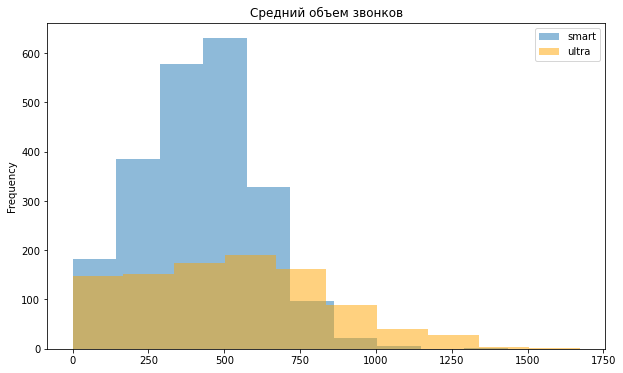

In [56]:
# представим распределение графически
ax = month_demand.query('tariff == "smart"').plot(y='calls_sum', figsize=(10, 6), kind='hist', label='smart', alpha=0.5)
month_demand.query('tariff == "ultra"').plot(y='calls_sum', figsize=(10, 6), kind='hist', label='ultra', alpha=0.5, color = 'Orange', ax=ax)
plt.title('Средний объем звонков')
plt.show()

Лимит для тарифов по минутам - 500 и 3000 минут.

Из значений среднего и отклонения можно сделать вывод, что большинство клиентов Смарт используют количество минут, близкое к лимиту тарифа. Но, как видно из графика, часть абонентов тарифа Смарт использует большее количество минут, чем заложено в тариф. Им можно предложить перейти на Ультра.

Количество минут, которые тратят клиенты Ультра в месяц, распределено равномерно, но с гораздо большим разбросом, чем у клиентов Смарт. Лимит тарифа не выговаривает никто из клиентов Ультра.

В общем клиенты Смарт разговаривают большее количество минут, чем клиенты Ультра. Скорее всего, их больше в выборке, значит тариф Смарт популярнее.

Посмотрим, какое количество трафика использовали абоненты каждого тарифа в месяц

In [57]:
print('Средний объем трафика за месяц в тарифе Смарт')
stat(month_demand.query('tariff == "smart"')['gb_used'])

Средний объем трафика за месяц в тарифе Смарт
Среднее: 16.33 Дисперсия: 33.01 Отклонение: 5.75


In [58]:
print('Средний объем трафика за месяц в тарифе Ультра')
stat(month_demand.query('tariff == "ultra"')['gb_used'])

Средний объем трафика за месяц в тарифе Ультра
Среднее: 19.49 Дисперсия: 96.99 Отклонение: 9.85


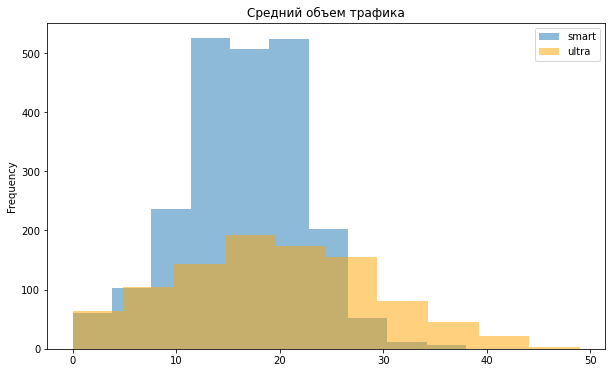

In [59]:
# представим распределение графически
ax = month_demand.query('tariff == "smart"').plot(y='gb_used', figsize=(10, 6), kind='hist', label='smart', alpha=0.5)
month_demand.query('tariff == "ultra"').plot(y='gb_used', figsize=(10, 6), kind='hist', label='ultra', alpha=0.5, color = 'Orange', ax=ax)
plt.title('Средний объем трафика')
plt.show()


Лимит для тарифов по трафику - 15 и 30 Гб.

Разброс значений потребляемого трафика у клиентов Ультра больше, чем у клиентов Смарт. 

Больше половины клиентов Смарт используют больше трафика, чем заложено в тарифе. В этот раз в тарифе Ультра тоже есть клиенты, превышающие лимит трафика. Похоже, интернет большинство клиентов использует более активно, чем звонки.

Посмотрим, какое количество сообщений отправили абоненты каждого тарифа в месяц

In [60]:
print('Средний объем сообщений за месяц в тарифе Смарт')
stat(month_demand.query('tariff == "smart"')['messages_count'])

Средний объем сообщений за месяц в тарифе Смарт
Среднее: 33.38 Дисперсия: 796.46 Отклонение: 28.22


In [61]:
print('Средний объем сообщений за месяц в тарифе Ультра')
stat(month_demand.query('tariff == "ultra"')['messages_count'])

Средний объем сообщений за месяц в тарифе Ультра
Среднее: 49.36 Дисперсия: 2282.95 Отклонение: 47.78


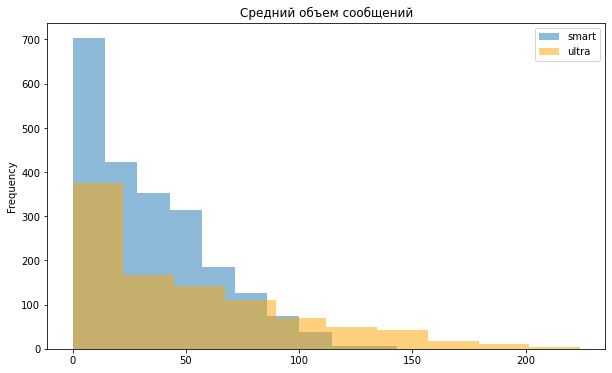

In [62]:
# представим распределение графически
ax = month_demand.query('tariff == "smart"').plot(y='messages_count', figsize=(10, 6), kind='hist', label='smart', alpha=0.5)
month_demand.query('tariff == "ultra"').plot(y='messages_count', figsize=(10, 6), kind='hist', label='ultra', alpha=0.5, color = 'Orange', ax=ax)
plt.title('Средний объем сообщений')
plt.show()

Лимит сообщений в тарифах - 50 и 1000.

Оба графика смещены к нулю. Кажется, сообщения - не самый популярный метод общения. Хотя среди клиентов Смарт есть те, кто превышает лимит.

Общее количество сообщений у клиентов Смарт больше, чем у клиентов Ультра, но не так значительно, как было со звонками и трафиком.

Теперь проверим следующие гипотезы:

    - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

В нулевой гипотезе всегда должно быть равенство, поэтому для первой гипозезы нулевая будет звучать так: Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая.

А альтернативная так: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

С помощью написанной ранее функции рассчитаем статистические показатели для выручки по обоим тарифам.

In [63]:
print('Средняя выручка за месяц в тарифе Смарт')
stat(month_demand.query('tariff == "smart"')['revenue'])

Средняя выручка за месяц в тарифе Смарт
Среднее: 1289.97 Дисперсия: 669485.22 Отклонение: 818.22


In [64]:
print('Средняя выручка за месяц в тарифе Ультра')
stat(month_demand.query('tariff == "ultra"')['revenue'])

Средняя выручка за месяц в тарифе Ультра
Среднее: 2070.15 Дисперсия: 141373.07 Отклонение: 376.0


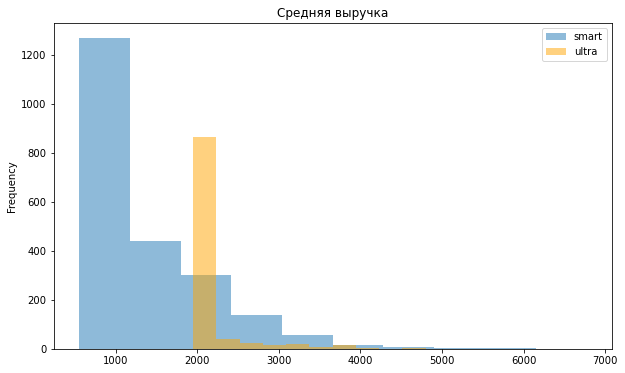

In [65]:
# представим распределение графически
ax = month_demand.query('tariff == "smart"').plot(y='revenue', figsize=(10, 6), kind='hist', label='smart', alpha=0.5)
month_demand.query('tariff == "ultra"').plot(y='revenue', figsize=(10, 6), kind='hist', label='ultra', alpha=0.5, color = 'Orange', ax=ax)
plt.title('Средняя выручка')
plt.show()

По среднему и графику видно, что выручка по тарифу Ультра должна быть выше, чем по тарифу Смарт. 

Проверим с помощью t-теста, подтвердится ли нулевая гипотеза.

У нас есть две довольно большие независимые выборки. Выборки разные по размеру, и средние выборок по тарифам сильно различаются, поэтому критический уровень статистической значимости возьмем маленький. Дисперсии разные, поэтому используем equal_var = False

In [66]:
alpha = 0.001 # уровень статистической значимости

results = st.ttest_ind(
    month_demand.query('tariff == "smart"')['revenue'],
    month_demand.query('tariff == "ultra"')['revenue'],
    equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

p-value: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


С помощью t-теста мы выяснили, что нулевая гипотеза не подтвердилась, и нам нужно принять альтернативную: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [67]:
# количество клиентов Смарт
month_demand.query('tariff == "smart"').groupby(by=['user_id'])['user_id'].count().count()

350

In [68]:
# количество клиентов Ультра
month_demand.query('tariff == "ultra"').groupby(by=['user_id'])['user_id'].count().count()

148

Исходя из рассчитанных средних можно сделать предположение, что выручка по тарифу Ультра выше, чем по тарифу Смарт. Но тут стоит учесть, что пользователей тарифа Смарт больше, чем Ультра, поэтому бОльшую часть суммарного объема выручки может давать Смарт. Это можно дополнительно исследовать. К тому же стоит учесть, что не все пользователи Смарт захотят перейти на Ультра, если нужно оставить один тариф. Но можно подумать, как повысить лояльность пользователей к интересному для оператора тарифу.

Теперь проверим вторую гипотезу, и для нее нулевая будет звучать так: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

А альтернативная так: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Рассчитаем статистические показатели для обоих тарифов в Москве и других регионах.

In [69]:
print('Средняя выручка за месяц в тарифе Смарт')
stat(month_demand.query('city == "Москва"')['revenue'])

Средняя выручка за месяц в тарифе Смарт
Среднее: 1546.71 Дисперсия: 564710.71 Отклонение: 751.47


In [70]:
print('Средняя выручка за месяц в тарифе Смарт')
stat(month_demand.query('city != "Москва"')['revenue'])

Средняя выручка за месяц в тарифе Смарт
Среднее: 1524.94 Дисперсия: 653886.33 Отклонение: 808.63


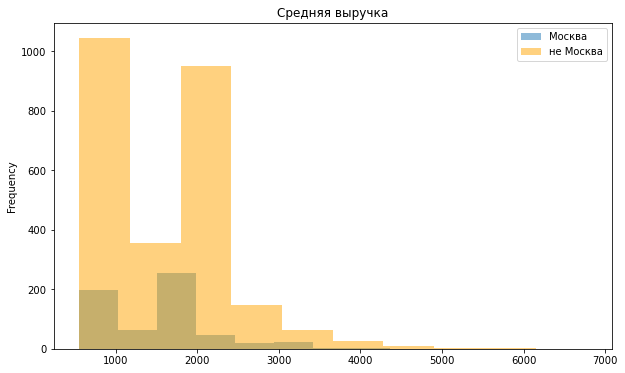

In [71]:
# представим распределение графически
ax = month_demand.query('city == "Москва"').plot(y='revenue', figsize=(10, 6), kind='hist', label='Москва', alpha=0.5)
month_demand.query('city != "Москва"').plot(y='revenue', figsize=(10, 6), kind='hist', label='не Москва', alpha=0.5, color = 'Orange', ax=ax)
plt.title('Средняя выручка')
plt.show()

Средние для Москвы и регионов очень похожи, да и график говорит о близости значений.

Проверим с помощью t-теста, подтвердится ли нулевая гипотеза.

Выборки разные по размеру, но средние выборок довольно близки, поэтому критический уровень статистической значимости возьмем высокий. Дисперсии разные, поэтому используем equal_var = False

In [72]:
alpha = 0.1 # уровень статистической значимости

results = st.ttest_ind(
    month_demand.query('city == "Москва"')['revenue'],
    month_demand.query('city != "Москва"')['revenue'],
    equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

p-value: 0.5257376663729298
Принимаем нулевую гипотезу


По результатам t-теста мы принимаем нулевую гипотезу: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

### Вывод
<a id='stage5_'></a>

Самой большой популярностью среди клиентов обоих тарифов пользуется интернет, самой низкой - сообщения.

Среди клиентов Смарт есть превышения лимита по звонкам, трафику и сообщениям. Можно провести дополнительный анализ, и предложить им перейти на Ультра, если:

    - есть превышение хотя бы по трафику и звонкам 
    - превышение только по одному показателю, но существенное
    
Клиенты тарифа Смарт в общем используют больше минут, трафика и сообщений, чем клиенты Ультра. По всей видимости, Смарт популярнее.

Гипотеза о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются, подтвердилась. Выручка по тарифу Ультра выше, чем по тарифу Смарт. Дополнительно можно исследовать суммарный объем выручки в месяц по каждому тарифу (скорее всего, для Смарт он выше, чем для Ультра, потому что клиентов Смарт больше). 

Если оператор связи решит оставить только наиболее выгодный тариф Ультра, стоит учесть, что пользователей Смарт большинство, и не все они захотят перейти на Ультра. Можно подумать, как повысить лояльность пользователей к интересному для оператора тарифу.

Гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов не подтвердилась - выручка в среднем близка к одинаковой для всех клиентов, независимо от места их проживания.

## Общий вывод
<a id='end'></a>

[к содержанию](#start)

В данном исследовании перед нами стояла задача: определить, какой из двух тарифных планов оператора сотовой связи - Смарт или Ультра - приносит бОльшую прибыль. Нужно было сделать предварительный анализ тарифов по данным за 2018 год на небольшой выборке клиентов - 500 человек.

Чтобы достичь целей исследования, мы предприняли следующие шаги:

    1. Изучили данные. Данные целочисленного, вещественного и строкового типов, без пропусков, которые нужно обрабатывать.
    
    2. Провели предобработку данных. Все данные проверены на дубликаты и аномалии, тип данных для столбцов с датами изменен на формат времени datetime. 
    
    3. Расчитали недостающие для исследования параметры и создали датафрейм, содержащий показатели расходов звонков, сообщений и трафика каждым пользователем по месяцам. 
   
    4. Проанализировали полученные данные.
    

Для прочтения выводов напомним лимиты для тарифов Смарт и Ультра соответственно: 

    - по минутам - 500 и 3000 минут
    - по трафику - 15 и 30 Гб
    - по сообщениям - 50 и 1000 сообщений
    
В ходе анализа мы получили следующие выводы:

1. По количеству минут разговора:
        
       - Большинство клиентов Смарт используют количество минут, близкое к лимиту тарифа - 418 минут (в среднем от 228 до 608 минут). Больше трети абонентов тарифа Смарт использует большее количество минут, чем заложено в тариф. 

       - Лимит тарифа не выговаривает никто из клиентов Ультра - большинство разговаривает около 527 минут (в среднем от 210 до 844 минут).
    
2. По количеству потребляемого трафика: 
        
       - Большинство клиентов Смарт потребляют около 16 Гб трафика (в среднем от 10 до 22 Гб). Больше половины клиентов Смарт используют больше трафика, чем заложено в тарифе.

       - Большинство клиентов Ультра используют около 20 Гб трафика (в среднем от 30 до 40 Гб). Около 20% клиентов превышают лимит трафика. 

       - Интернет большинство клиентов использует более активно, чем звонки. 
    
3. По количеству отправленных сообщений:
        
       - Большинство клиентов Смарт отправляют около 33 сообщений в месяц (в среднем от 5 до 61 сообщения), около трети клиентов превышает лимит.
    
       - Клиенты Ультра отправляют в основном около 49 сообщений (в среднем от 2 до 96 сообщений), лимит не превышается.
    
       - Сообщениями клиенты общаются меньше всего. 

4. По выручке:
    
       - Выручка по тарифу Ультра выше, чем по тарифу Смарт - в среднем 2070 рублей и 1290 рублей в месяц соответственно.
    
       - Выручка в среднем близка к одинаковой для клиентов, проживающих в Москве и в других регионах, и составляет около 1535 р. в месяц.
    
Дополнительные выводы:

    1. Около трети абонентов тарифа Смарт использует большее количество минут, трафика и сообщений, чем заложено в тариф. Им можно предложить перейти на Ультра.
    
    2. Тариф Смарт популярнее среди клиентов, чем тариф Ультра (в выборке 350 клиентов используют Смарт, и только 148 клиентов используют Ультра).
    
    3. Возможно, стоит разработать отдельный тариф для тех, кто активнее использует Интернет, чем звонки.
    
Рекомендации: 

    1. Дополнительно можно исследовать суммарный объем выручки в месяц по каждому тарифу (скорее всего, для Смарт он выше, чем для Ультра, потому что клиентов Смарт больше). 

    2. Стоит учесть, что не все пользователи Смарт захотят перейти на Ультра, если нужно оставить один тариф. Но можно подумать, как повысить лояльность пользователей к интересному для оператора тарифу.